In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler, Normalizer, LabelEncoder

%matplotlib inline

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test["is_promoted"] = np.nan
print train.shape, test.shape

(54808, 14) (23490, 14)


# Simple LGBM Model

In [3]:
train_id = train[["employee_id"]]
test_id = test[["employee_id"]]
target = train.is_promoted

train = train.drop(["employee_id","is_promoted"], axis=1)
test = test.drop(["employee_id","is_promoted"], axis=1)

data = pd.concat([train, test], axis=0).reset_index(drop=True)
data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
data["education"] = data["education"].fillna("NoData")

# Feature Engineering Start
data["department_size"] = data["department"].map(data.groupby("department").size())

data["department_average_training_scores"] = data["department"].map(data.groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_average_training_score_in_department"] = data.apply(lambda x: ((x["department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["department_average_training_scores"]), axis=1)
data = data.drop(["department_average_training_scores"], axis=1)

data["kpi_positive_department_average_training_scores"] = data["department"].map(data.loc[data["KPIs_met >80%"] ==1].groupby("department")["avg_training_score"].apply(lambda x: np.array(x)))
data["percentile_kpi_positive_average_training_score_in_department"] = data.apply(lambda x: ((x["kpi_positive_department_average_training_scores"] < x["avg_training_score"]).astype(int).sum() + ((x["kpi_positive_department_average_training_scores"] == x["avg_training_score"]).astype(int).sum()*0.5))/len(x["kpi_positive_department_average_training_scores"]), axis=1)
data = data.drop(["kpi_positive_department_average_training_scores"], axis=1)

# Feature Engineering End


data = pd.get_dummies(data, columns = data.select_dtypes(include='object').columns)

train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [4]:
def f1_score_calculator(y_true, y_pred):
    bst = 0
    split_by = 0.0
    for i in range(100):
        fs = f1_score(y_true, (y_pred>i/100.0).astype(int))
        if fs > bst:
            bst , split_by = fs, i/100.0
        else:
            pass
    return split_by, bst 

In [5]:
import lightgbm as lgb
def model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id):
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_test, label=y_test)
    params = {
        'num_leaves': 32, 
        'reg_alpha': 0.04, 
        'n_jobs': -1, 
        'colsample_bytree': 0.9497036, 
        'silent': -1, 
        'subsample_for_bin': 200000, 
        'subsample_freq': 1, 
        'learning_rate': 0.02, 
        'boosting_type': 'gbdt', 
        'nthread': 8, 
        'min_child_weight': 40, 
        'min_split_gain': 0.0222415, 
        'n_estimators': 10000, 
        'subsample': 0.8715623, 
        'reg_lambda': 0.073, 
        'objective': "binary",
        'verbose': -1, 
        'min_child_samples': 20, 
        'max_depth': 4, 
        'class_weight': None,
        "nthread":8,
        "bagging_seed" : 42,
        "seed":98,
        "metric":"auc"
    }
    model = lgb.train(params, dtrain, num_boost_round=5000,valid_sets=[dtrain, dval], early_stopping_rounds=200, verbose_eval=100)
    meta_train[test_index] = model.predict(x_test, num_iteration=model.best_iteration or 5000)
    split, bst = f1_score_calculator(y_test, meta_train[test_index])
    
    meta_train[test_index] = (meta_train[test_index] > split).astype(int)
    meta_test.append((model.predict(test, num_iteration=model.best_iteration or 5000) > split).astype(int))
    
    print "Fold {} best Split {} and best Score {}".format(fold_id,split, bst)
        
    # Calculate Feature Importance
    global feature_importance
    gain = model.feature_importance('gain')
    fold_feature_importance = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()})
    feature_importance = feature_importance.append(fold_feature_importance, ignore_index=True) 

In [6]:
meta_train = np.zeros(train.shape[0])
meta_test = []
feature_importance = pd.DataFrame()

kf = StratifiedKFold(n_splits= 30, shuffle=True, random_state=1343)
for fold_id, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    model_tree(x_train, x_test, y_train, y_test, test, meta_train, meta_test,train_index, test_index,fold_id)
print "Overall Score: {}".format(f1_score(target, meta_train))

train_id["is_promoted"] = meta_train
test_id["is_promoted"] = (np.array(meta_test).T.mean(axis=1) > 0.5).astype(int)

/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901858	valid_1's auc: 0.899437
[200]	training's auc: 0.909872	valid_1's auc: 0.907571
[300]	training's auc: 0.912279	valid_1's auc: 0.908608
[400]	training's auc: 0.914982	valid_1's auc: 0.908656
[500]	training's auc: 0.916761	valid_1's auc: 0.908759
Early stopping, best iteration is:
[353]	training's auc: 0.914236	valid_1's auc: 0.9091
Fold 0 best Split 0.2 and best Score 0.554054054054
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901756	valid_1's auc: 0.90504
[200]	training's auc: 0.910047	valid_1's auc: 0.91497
[300]	training's auc: 0.912999	valid_1's auc: 0.91875
[400]	training's auc: 0.915221	valid_1's auc: 0.921244
[500]	training's auc: 0.916984	valid_1's auc: 0.922245
[600]	training's auc: 0.918093	valid_1's auc: 0.922492
[700]	training's auc: 0.919413	valid_1's auc: 0.923065
[800]	training's auc: 0.920652	valid_1's auc: 0.923502
[900]	training's auc: 

[700]	training's auc: 0.919475	valid_1's auc: 0.906873
[800]	training's auc: 0.920532	valid_1's auc: 0.90665
[900]	training's auc: 0.921524	valid_1's auc: 0.90723
[1000]	training's auc: 0.922479	valid_1's auc: 0.907778
[1100]	training's auc: 0.923358	valid_1's auc: 0.907602
[1200]	training's auc: 0.924098	valid_1's auc: 0.907326
Early stopping, best iteration is:
[1038]	training's auc: 0.922797	valid_1's auc: 0.907878
Fold 10 best Split 0.28 and best Score 0.522088353414
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.901939	valid_1's auc: 0.903163
[200]	training's auc: 0.909582	valid_1's auc: 0.909762
[300]	training's auc: 0.912871	valid_1's auc: 0.912844
[400]	training's auc: 0.915448	valid_1's auc: 0.914664
[500]	training's auc: 0.916764	valid_1's auc: 0.915303
[600]	training's auc: 0.918147	valid_1's auc: 0.915408
[700]	training's auc: 0.919418	valid_1's auc: 0.915458
[800]	training's auc: 0.920513	valid_1's auc: 0.915435
[900]	training's auc:

[800]	training's auc: 0.920777	valid_1's auc: 0.911189
[900]	training's auc: 0.921833	valid_1's auc: 0.911336
[1000]	training's auc: 0.922691	valid_1's auc: 0.911417
[1100]	training's auc: 0.923353	valid_1's auc: 0.911424
Early stopping, best iteration is:
[953]	training's auc: 0.922326	valid_1's auc: 0.911625
Fold 21 best Split 0.3 and best Score 0.53164556962
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.9024	valid_1's auc: 0.891807
[200]	training's auc: 0.909786	valid_1's auc: 0.898344
[300]	training's auc: 0.912897	valid_1's auc: 0.898934
[400]	training's auc: 0.915528	valid_1's auc: 0.902141
[500]	training's auc: 0.917166	valid_1's auc: 0.902158
[600]	training's auc: 0.918396	valid_1's auc: 0.902268
[700]	training's auc: 0.919669	valid_1's auc: 0.902407
[800]	training's auc: 0.920725	valid_1's auc: 0.902728
[900]	training's auc: 0.921681	valid_1's auc: 0.902523
[1000]	training's auc: 0.922642	valid_1's auc: 0.902342
Early stopping, best ite

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold 29 best Split 0.2 and best Score 0.544776119403
Overall Score: 0.536344755971


In [10]:
test_id.to_csv("csv/prediction2.csv", index = False)

In [11]:
test_id["is_promoted"].mean()

0.04963814389101746

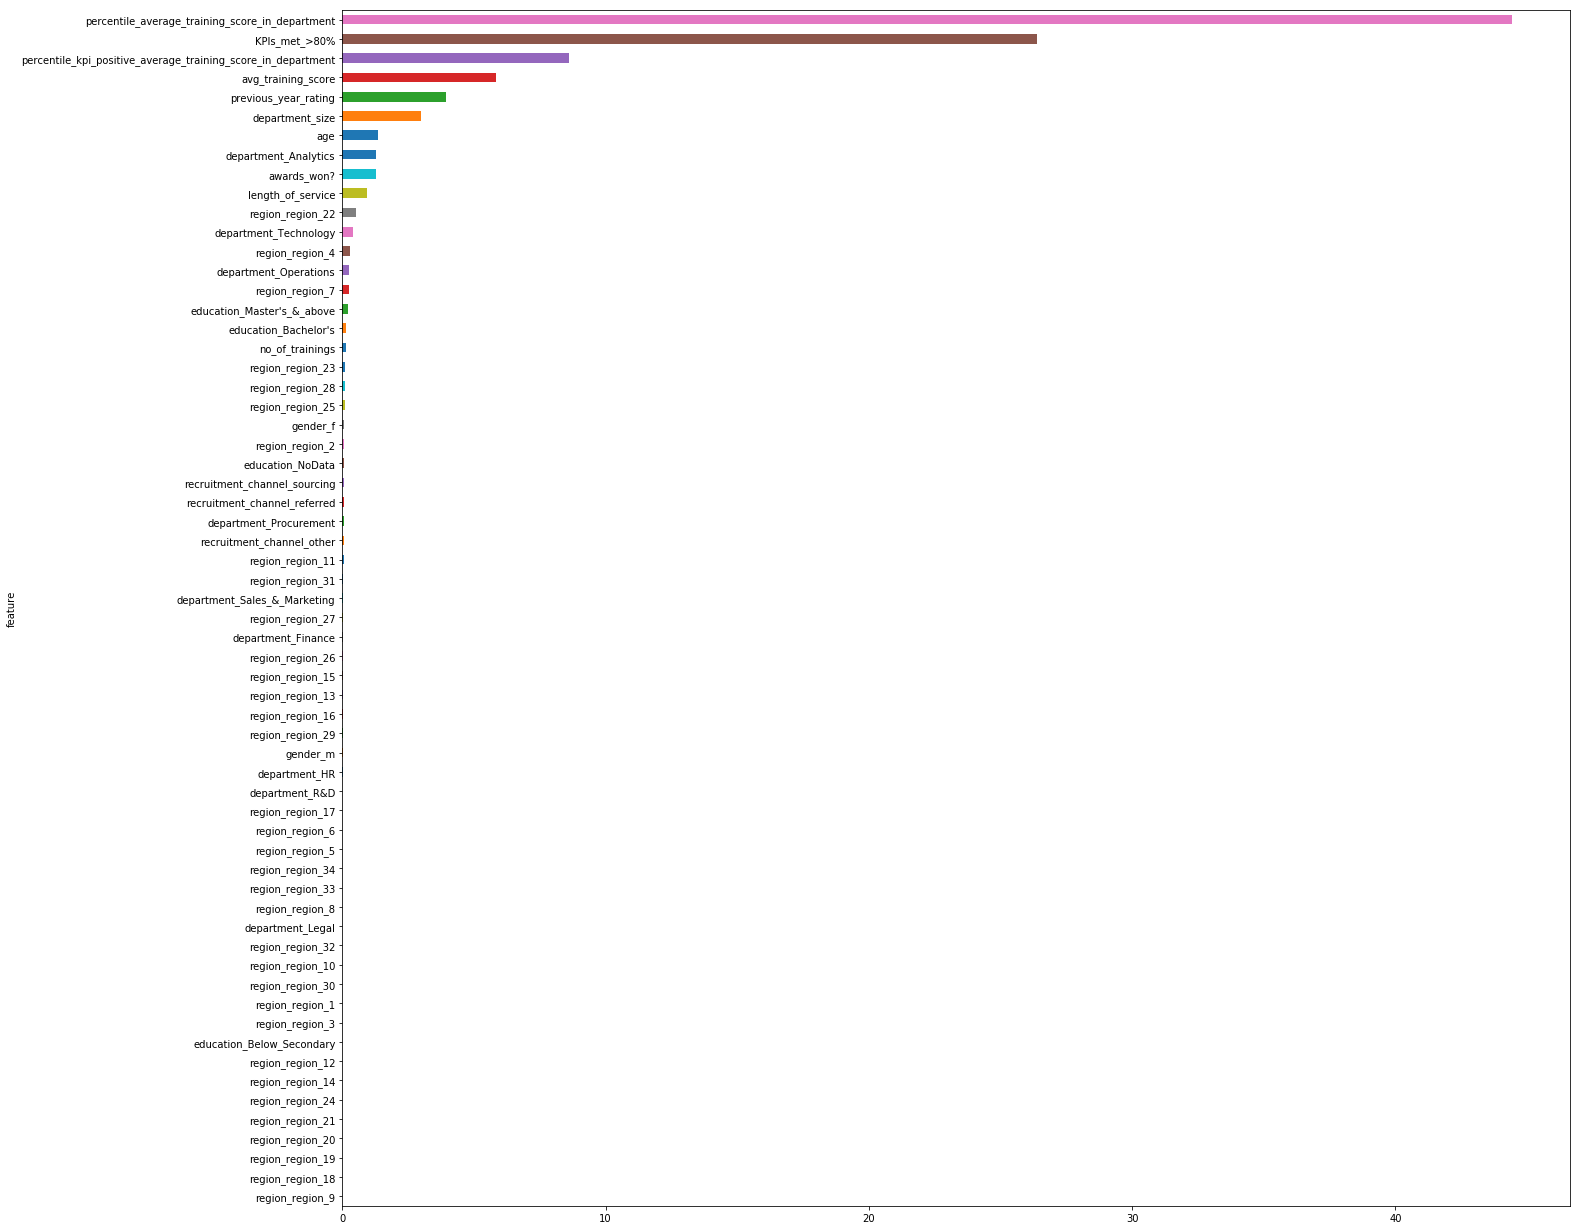

In [12]:
feature_importance.groupby("feature")["gain"].mean().sort_values().plot(kind = "barh", figsize = (22,22))